Authentication with EllipticManifold
===

<div class="alert alert-block alert-info"> 
Author: Nathan A. Mahynski

Date: 2023/08/23

Description: Illustrate modeling with the EllipticManifold model.
</div>

In <a href="https://doi.org/10.1016/S0169-7439(02)00107-7">projection methods</a> a dimensionality reduction is first performed to compress the data into a lower dimensional space; authentication can be performed by enveloping the projected points in an elliptical boundary.  The cutoff for this boundary can be determined using a Mahalanobis distance, for example.  DD-SIMCA uses a different statistical cutoff approach, but distance-based methods are common.
    
PCA and related approaches (e.g., SIMCA) perform linear dimensionality reduction.  This general authentication approach can be generalized by replacing the PCA with any non-linear dimensionality reduction step.  This is what the EllipticManifold model allows you to do; it is essentially the application of sklearn's <a href="https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope">EllipticEnvelope</a> fitted around the training data after undergoing some kind of dimensionality reduction.  It assumes the data follows a Gaussian distribution in the lower dimensional space.

In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !git clone https://github.com/mahynski/pychemauth.git --depth 1
    !cd pychemauth; pip3 install .; cd ..

try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sklearn.decomposition
import sklearn.manifold

from pychemauth.manifold.elliptic import EllipticManifold

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-26-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

matplotlib: 3.7.2
watermark : 2.4.3
pychemauth: 0.0.0b3
json      : 2.0.9
numpy     : 1.24.4
sklearn   : 1.3.0



<h3>Load the Data</h3>

In [4]:
from sklearn.datasets import load_iris as load_data
X, y = load_data(return_X_y=True, as_frame=True)

In [5]:
# Let's turn the indices into names
names = dict(zip(np.arange(3), ['setosa', 'versicolor', 'virginica'])) 
y = y.apply(lambda x: names[x])

In [6]:
X.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [7]:
from sklearn.model_selection import train_test_split
from pychemauth.preprocessing.scaling import CorrectedScaler

X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values, # Let's try to predict the salary based on the other numerical features.
    shuffle=True,
    random_state=42,
    test_size=0.2,
    stratify=y # It is usually important to balance the test and train set so they have the same fraction of classes
)

# Normally we would include this in a pipeline, but for these examples we will just do this ahead of time.
scaler = CorrectedScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Principal Components Analysis
---

<div class="alert alert-block alert-info"> 
We do not need to use a non-linear DR method.  As a first example, let's use PCA.
</div>

In [8]:
# If more than 1 class is used during training an exception is thrown
setosa = EllipticManifold(
    alpha=0.05, 
    dr_model=sklearn.decomposition.PCA, # A linear approach
    kwargs={'n_components':2}, # Keywords for the dr_model
    ndims='n_components', # The keyword that corresponds to the dimensionality of space
    robust=True, # Estimate the covariance matrix for the Mahalanobis distance using a robust approach
    center='score' # Center the ellipse around the emperical mean of the projected data
)

_ = setosa.fit(
    X_train[y_train == 'setosa'], 
    y_train[y_train == 'setosa']
)

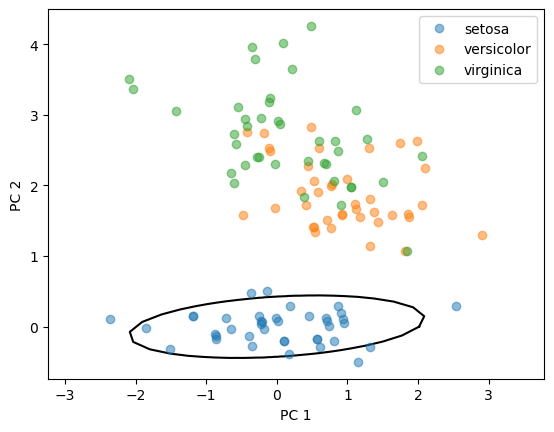

In [9]:
_ = setosa.visualize(
    [
        X_train[y_train == 'setosa'],
        X_train[y_train == 'versicolor'],
        X_train[y_train == 'virginica']
    ], 
    ['setosa', 'versicolor', 'virginica']
)

In [10]:
# Predict how many training examples are considered inliers
setosa.predict(X_train[y_train == 'setosa'])

array([False,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True])

In [11]:
# Predict if the other classes are considered inliers
setosa.predict(X_train[y_train != 'setosa'])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

<Axes: xlabel='Expected', ylabel='Observed'>

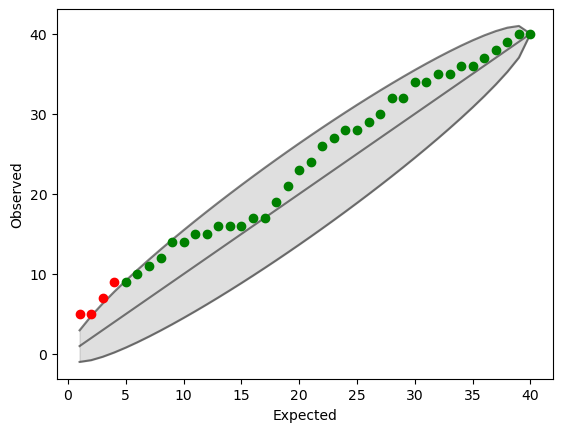

In [12]:
# The extremes plot helps you understand how Gaussian the data in the reduced dimensionality space
setosa.extremes_plot(X_train[y_train == 'setosa'], upper_frac=1.0)

Kernel PCA
---

<div class="alert alert-block alert-info"> 
PCA can be made non-linear by switching to kernel PCA. See <a href="https://scikit-learn.org/stable/modules/decomposition.html#kernel-pca">scikit-learn's documentation</a> for details on hyperparameters.
</div>

In [13]:
setosa = EllipticManifold(
    alpha=0.05, 
    dr_model=sklearn.decomposition.KernelPCA, 
    kwargs={'n_components': 2, 'kernel': 'cosine'}, 
    ndims='n_components', 
    robust=True, 
    center='score' 
)

_ = setosa.fit(
    X_train[y_train == 'setosa'], 
    y_train[y_train == 'setosa']
)

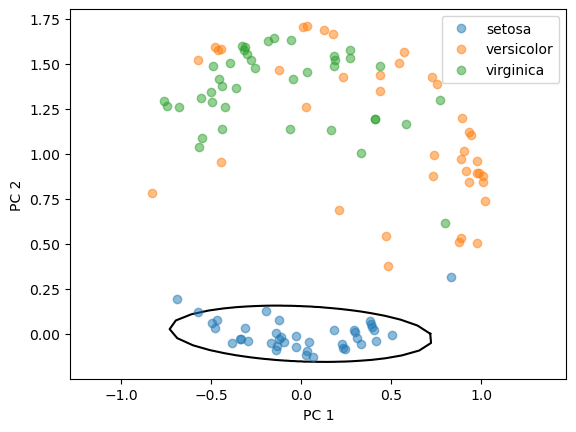

In [14]:
_ = setosa.visualize(
    [
        X_train[y_train == 'setosa'],
        X_train[y_train == 'versicolor'],
        X_train[y_train == 'virginica']
    ], 
    ['setosa', 'versicolor', 'virginica']
)

<Axes: xlabel='Expected', ylabel='Observed'>

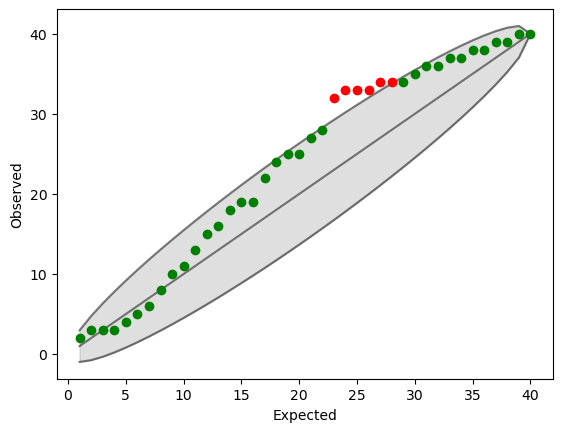

In [15]:
setosa.extremes_plot(X_train[y_train == 'setosa'], upper_frac=1.0)

Isometric Map
---

<div class="alert alert-block alert-info"> 
Isometric mapping is another non-linear DR approach.  You can read more in <a href="https://scikit-learn.org/stable/modules/manifold.html#isomap">scikit-learn's documentation</a>.
</div>

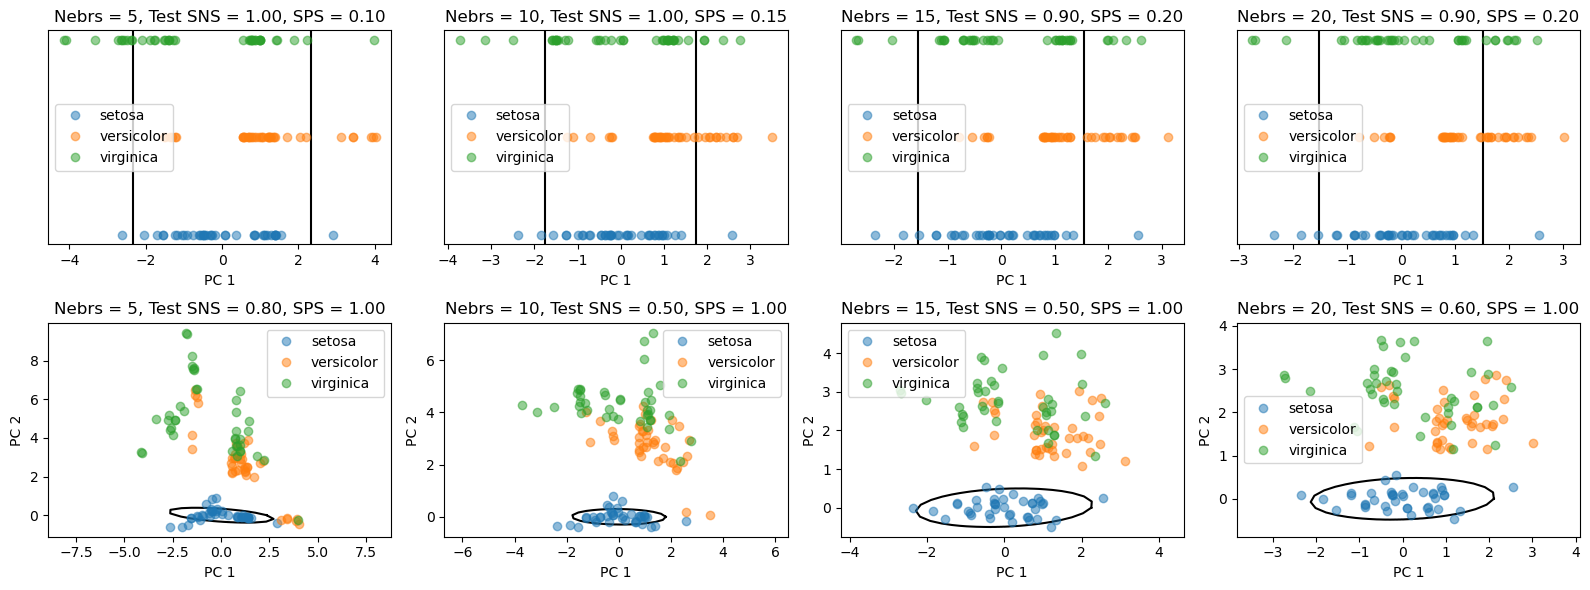

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,6))
ax = axes.flatten()

idx = 0
for dims in [1, 2]:
    for nebrs in [5, 10, 15, 20]:
        setosa = EllipticManifold(
            alpha=0.05, 
            dr_model=sklearn.manifold.Isomap, 
            kwargs={"n_components": dims, "metric":'minkowski', "p":2, "n_neighbors":nebrs}, 
            ndims="n_components", 
            robust=True, 
            center='score' 
        )
        _ = setosa.fit(X_train[y_train == 'setosa'])
        
        _ = setosa.visualize(
            [
                X_train[y_train == 'setosa'],
                X_train[y_train == 'versicolor'],
                X_train[y_train == 'virginica']
            ], 
            ['setosa', 'versicolor', 'virginica'],
            ax=ax[idx]
        )
        
        test_sns = np.sum(setosa.predict(X_test[y_test == 'setosa'])) / np.sum(y_test == 'setosa')
        test_sps = 1.0 - np.sum(setosa.predict(X_test[y_test != 'setosa'])) / np.sum(y_test != 'setosa')

        ax[idx].set_title('Nebrs = {}, Test SNS = {}, SPS = {}'.format(nebrs, '%.2f'%test_sns, '%.2f'%test_sps))
        idx += 1
plt.tight_layout()

LLE Example
---

<div class="alert alert-block alert-info"> 
Locally linear embedding mapping is another non-linear DR approach.  You can read more in <a href="https://scikit-learn.org/stable/modules/manifold.html#locally-linear-embedding">scikit-learn's documentation</a>.
</div>

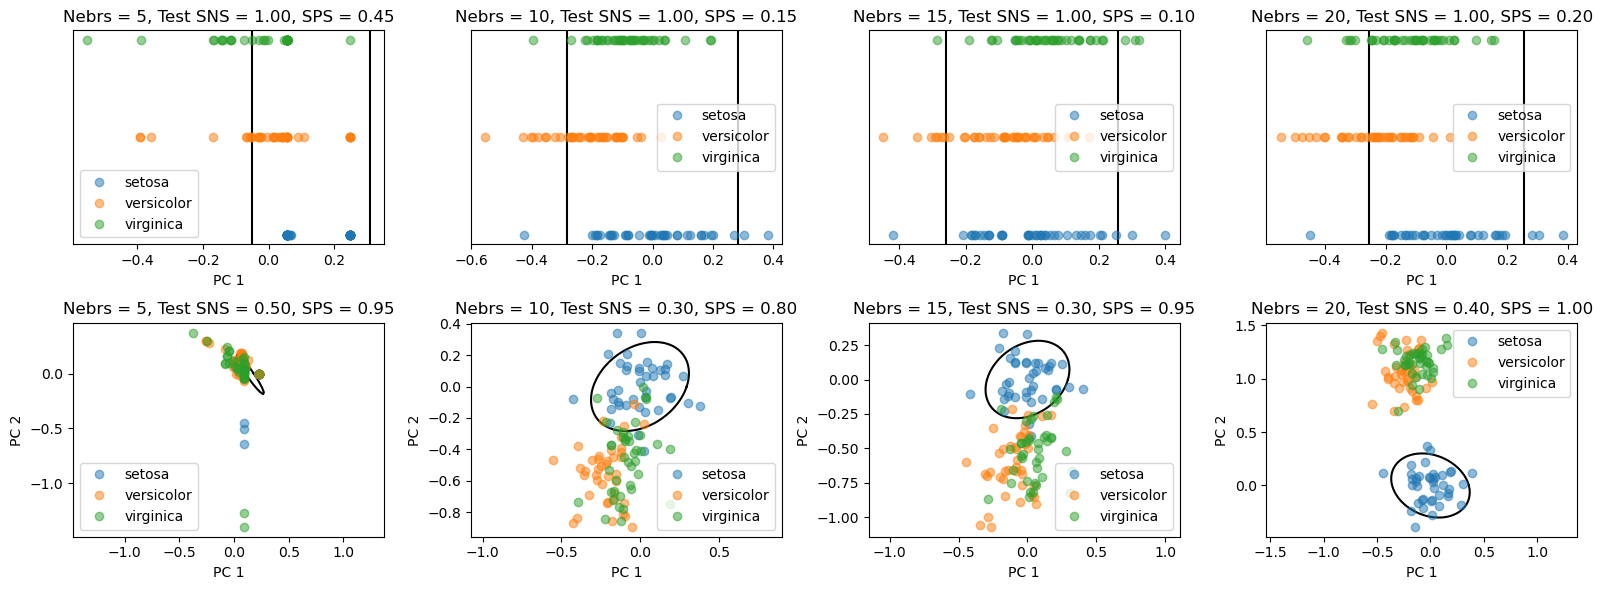

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,6))
ax = axes.flatten()

idx = 0
for dims in [1, 2]:
    for nebrs in [5, 10, 15, 20]:
        setosa = EllipticManifold(
            alpha=0.05, 
            dr_model=sklearn.manifold.LocallyLinearEmbedding, 
            kwargs={"n_components": dims, "n_neighbors":nebrs}, 
            ndims="n_components", 
            robust=True, 
            center='score' 
        )
        _ = setosa.fit(X_train[y_train == 'setosa'])
        
        _ = setosa.visualize(
            [
                X_train[y_train == 'setosa'],
                X_train[y_train == 'versicolor'],
                X_train[y_train == 'virginica']
            ], 
            ['setosa', 'versicolor', 'virginica'],
            ax=ax[idx]
        )
        
        test_sns = np.sum(setosa.predict(X_test[y_test == 'setosa'])) / np.sum(y_test == 'setosa')
        test_sps = 1.0 - np.sum(setosa.predict(X_test[y_test != 'setosa'])) / np.sum(y_test != 'setosa')

        ax[idx].set_title('Nebrs = {}, Test SNS = {}, SPS = {}'.format(nebrs, '%.2f'%test_sns, '%.2f'%test_sps))
        idx += 1
plt.tight_layout()

UMAP Example
---

UMAP has a lot of parameters that should be understood before using it.  See the [documentation](https://umap-learn.readthedocs.io/en/latest/parameters.html) for explanation. Briefly, there are 4 that matter the most:
* n_neighbors
* n_components
* metric
* min_dist

**IMPORTANTLY** you should always set random_state to ensure reproducibility between runs since UMAP is stochastic.

In [ ]:
import umap

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,6))
ax = axes.flatten()

idx = 0
for dims in [1, 2]:
    scores = []
    for nebrs in [5, 15, 30]:
        model = umap.UMAP
        kwargs = {"n_neighbors":nebrs, # Less focuses on finer detail, more is "bigger picture"
                  "n_components":dims, # Final dimensionality
                  "random_state":0, # Always set this for reproducibility
                  "metric":"euclidean", # How to compute distance between points in the ambient input space
                  "min_dist":1.0 # Closest points are allowed to come in the embedding (only controls training data, test can end up closer)
                 }
        m = EllipticManifold(0.05, model, kwargs)
        _ = m.fit(X_train_scaled)
        train_score = m.score(X_train_scaled, [1]*len(X_train_scaled))
        test_score = m.score(X_test_scaled, [1]*len(X_test_scaled))
        x1_score = m.score(X_1_scaled, [0]*len(X_1_scaled))
        x2_score = m.score(X_2_scaled, [0]*len(X_2_scaled))
        scores.append([train_score, test_score, x1_score, x2_score])
        
        ax_ = m.visualize([X_train_scaled, X_test_scaled, X_1_scaled, X_2_scaled], ["Training Set", "Test Set", "Class 1", "Class 2"], ax[idx])
        ax_.set_title('Nebrs = {}, Test Score = {}\nX_1 Score = {}, X_2 Score = {}'.format(
            nebrs, '%.3f'%test_score, '%.3f'%x1_score, '%.3f'%x2_score))
        idx += 1
    scores = np.array(scores)
    ax[idx].plot([5, 15, 30], scores[:, 0], '-o', alpha=0.5, label='Train')
    ax[idx].plot([5, 15, 30], scores[:, 1], '-s', alpha=0.5, label='Test')
    ax[idx].plot([5, 15, 30], scores[:, 2], '-*', alpha=0.5, label='X_1')
    ax[idx].plot([5, 15, 30], scores[:, 3], '-^', alpha=0.5, label='X_2')
    ax[idx].set_xlabel('Nebrs')
    ax[idx].set_ylabel('Score')
    ax[idx].legend(loc='best')
    idx += 1

plt.tight_layout()